## Firstly we create a toy data distribution

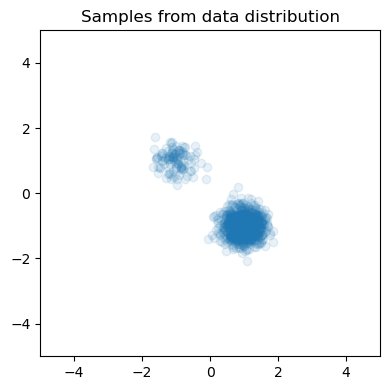

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.distributions import Normal, Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import os

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(0)

D = 10.
M = D+5
VAR = 0.1
DOT_SIZE = 4
COMP = 3

initial_mix = Categorical(torch.tensor([0.1,0.7]))

initial_comp = MultivariateNormal(torch.tensor([[-1.0, 1.0], [1.0, -1.0]]).float(), VAR * torch.stack([torch.eye(2) for i in range(2)]))

initial_model = MixtureSameFamily(initial_mix, initial_comp)
samples_1 = initial_model.sample([1000])

target_mix = Categorical(torch.tensor([0.7,0.1]))

target_comp = MultivariateNormal(torch.tensor([[0.5, 0.5], [0.5, 0.5]]).float(), VAR * torch.stack([torch.eye(2) for i in range(2)]))
target_model = MixtureSameFamily(target_mix, target_comp)
samples_0 = target_model.sample([1000])

plt.figure(figsize=(4,4))
plt.title(r'Samples from data distribution')
plt.scatter(samples_1[:, 0].cpu().numpy(), samples_1[:, 1].cpu().numpy(), alpha=0.1)
plt.xlim(-5.,5.)
plt.ylim(-5.,5.)
plt.tight_layout()

## We can use MMD to give a quantative evaluation of generation result 

In [13]:
from sklearn import metrics

def mmd_rbf(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})
    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()

## Simply use a MLP as the network

In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_num=100):
        super().__init__()
        self.fc1 = nn.Linear(input_dim+1, hidden_num, bias=True)
        self.fc2 = nn.Linear(hidden_num, hidden_num, bias=True)
        self.fc3 = nn.Linear(hidden_num, input_dim, bias=True)
        self.act = lambda x: torch.tanh(x)
    
    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=-1)
        x = self.fc1(inputs)

        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)

        return x

## The Bayesian flow networks class definition

In [ ]:
class Baysian_Flows(nn.Module):
    def __init__(self, model=None, t_min=0.0001, sigma1=0.02):
        super().__init__()
        self.model = model
        self.t_min = t_min
        self.sigma1 = torch.tensor(sigma1).cuda()
        self.sigma1.requires_grad = False

    def corrupt_t_pred(self, mu, t, gamma):
        eps_pred = self.model(mu, t)
        x_pred = mu / gamma - torch.sqrt((1 - gamma) / gamma) * eps_pred
        return x_pred

    def get_train_tuple(self, z0=None, z1=None):
        t = torch.rand((z1.shape[0], 1)).to(z0.device)
        z_t = t * z1 + (1.0 - t) * z0
        target = z1 - z0
        return z_t, t, target

    def forward(self, t, x):
        t = torch.ones((x.size(0), 1)).cuda() * t
        return self.model(x, t)

    @torch.no_grad()
    def Sampling_BFN(self, N=10, samples_nums=2000):
        mu = torch.zeros((samples_nums, 2)).cuda()
        ro = 1
        if N is None:
            N = self.N
        traj = []  # to store the trajectory
        for i in range(1, N + 1):
            t = torch.ones((samples_nums, 1)).cuda() * (i - 1) / N
            t = torch.clamp(t, min=self.t_min)
            gamma = 1 - torch.pow(self.sigma1, 2 * t)
            x_pred = self.corrupt_t_pred(mu, t, gamma)
            alpha = torch.pow(self.sigma1, -2 * i / N) * (
                1 - torch.pow(self.sigma1, 2 / N)
            )

            y = x_pred + torch.randn_like(x_pred) * torch.sqrt(1 / alpha)
            mu = (ro * mu + alpha * y) / (ro + alpha)
            ro = ro + alpha
            traj.append(x_pred.detach().clone())

        x_final_pred = self.corrupt_t_pred(
            mu, torch.ones((samples_nums, 1)).cuda(), 1 - self.sigma1**2
        )
        traj.append(x_final_pred.detach().clone())
        return traj

    def BFN_loss(self, z1):
        t = torch.rand((z1.shape[0], 1)).to(z1.device)
        sigma = self.sigma1 * torch.ones_like(t)
        gamma = 1 - torch.pow(sigma, 2 * t)
        mu = gamma * z1 + torch.randn_like(z1) * torch.sqrt(gamma * (1 - gamma))
        x_pred = self.corrupt_t_pred(mu, t, gamma)
        loss = (x_pred - z1).view(z1.shape[0], -1).abs().pow(2).sum(dim=1)

        return -torch.log(self.sigma1) * loss * torch.pow(self.sigma1, -2 * t)

    def BFN_loss_discrete(self, z1, N=10):
        i = torch.randint(1, N + 1, (z1.shape[0], 1)).to(z1.device).float()
        t = (i - 1) / N * torch.ones((z1.shape[0], 1)).cuda()
        t = torch.clamp(t, min=self.t_min)
        gamma = 1 - torch.pow(self.sigma1, 2 * t)
        mu = gamma * z1 + torch.randn_like(z1) * torch.sqrt(gamma * (1 - gamma))
        x_pred = self.corrupt_t_pred(mu, t, gamma)
        weight = (
            N
            * (1 - torch.pow(self.sigma1, 2 / N))
            / (2 * torch.pow(self.sigma1, 2 * i / N))
        )

        return weight * (x_pred - z1).view(z1.shape[0], -1).abs().pow(2).sum(dim=1)

In [5]:
def train_BFN_continous(BFN, optimizer, pairs, batchsize, inner_iters):
    loss_curve = []
    for i in range(inner_iters + 1):
        optimizer.zero_grad()
        indices = torch.randperm(len(pairs))[:batchsize]
        batch = pairs[indices]
        z0 = batch[:, 0].detach().clone()
        z1 = batch[:, 1].detach().clone()
        # z_t, t, target = rectified_flow.get_train_tuple(z0=z0, z1=z1)
        loss = BFN.BFN_loss_discrete(z1)
        loss = loss.mean()
        loss.backward()

        if i % 1000 == 0:
            print(i, "loss:", loss.item())

        optimizer.step()
        loss_curve.append(np.log(loss.item()))  ## to store the loss curve

    return BFN, loss_curve

In [9]:
@torch.no_grad()
def draw_plot(BFN, z1, N=None, traj=None):
  z1 = z1.cuda()
  if traj is None:
    samples_nums = z1.shape[0]
    traj = BFN.Sampling_BFN(N=N,samples_nums=samples_nums)
  
  plt.figure(figsize=(4,4))
  plt.xlim(-5.,5.)
  plt.ylim(-5.,5.)
    
  plt.scatter(z1[:, 0].cpu().numpy(), z1[:, 1].cpu().numpy(), label=r'$\pi_1$', alpha=0.15)
  plt.scatter(traj[-1][:, 0].cpu().numpy(), traj[-1][:, 1].cpu().numpy(), label='Generated', alpha=0.15)
  plt.legend()
  plt.title('Distribution')
  plt.tight_layout()
  traj_particles = torch.stack(traj)
  print(f'traj:{traj_particles.shape}')
  plt.figure(figsize=(4,4))
  plt.xlim(-1.,1.)
  plt.ylim(-3.,3.)
  plt.axis('equal')
  for i in range(100):
    plt.plot(traj_particles[:, i, 0].cpu().numpy(), traj_particles[:, i, 1].cpu().numpy())
  plt.title('Transport Trajectory')
  plt.tight_layout()
  
  mmd = mmd_rbf(z1.cpu().numpy(), traj[-1].cpu().numpy(), gamma=0.1)
  print('MMD:', mmd)

  straightness = 0.0
  straight_v = traj_particles[-1] - traj_particles[0]
  for i in range(N):
    v = (traj_particles[i+1] - traj_particles[i]) * N
    straightness += (v - straight_v).norm(dim=1).mean() 

  print('Straightness:', straightness / N)


0 loss: 320058.25
1000 loss: 1340.2197265625
2000 loss: 867.8573608398438
3000 loss: 347.1260070800781
4000 loss: 303.92852783203125
5000 loss: 442.1672058105469
6000 loss: 424.9427490234375
7000 loss: 299.4527587890625
8000 loss: 458.1165466308594
9000 loss: 251.74026489257812
10000 loss: 440.69781494140625


Text(0.5, 1.0, 'Training Loss Curve')

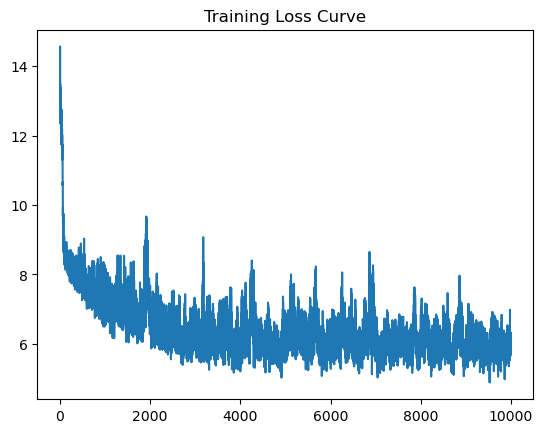

In [7]:
x_0 = samples_0.detach().clone()[torch.randperm(len(samples_0))]
indices = torch.randint(low=0, high=samples_1.shape[0], size=(1000,))
x_1 = samples_1.detach().clone()[indices]
x_pairs = torch.stack([x_0, x_1], dim=1)

iterations = 10000
batchsize = 512
input_dim = 2

x_pairs = x_pairs.cuda()

BFN = Baysian_Flows(model=MLP(input_dim, hidden_num=200).cuda(),sigma1=0.02)
optimizer = torch.optim.Adam(BFN.model.parameters(), lr=1e-2)

BFN, loss_curve = train_BFN_continous(BFN, optimizer, x_pairs, batchsize, iterations)
plt.plot(np.linspace(0, iterations, iterations+1), loss_curve[:(iterations+1)])
plt.title('Training Loss Curve')
# draw_plot(BFN, z0=initial_model.sample([2000]), z1=samples_1.detach().clone(), N=100)


## We can see BFN fit the data distribution well

traj:torch.Size([101, 1000, 2])
MMD: 0.0033217668533325195
Straightness: tensor(45.6748, device='cuda:0')


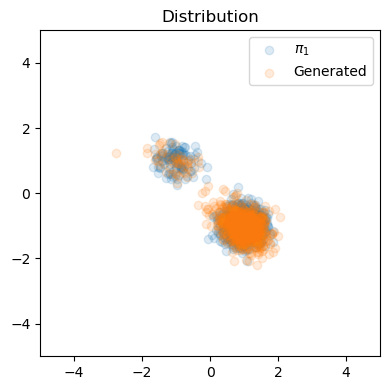

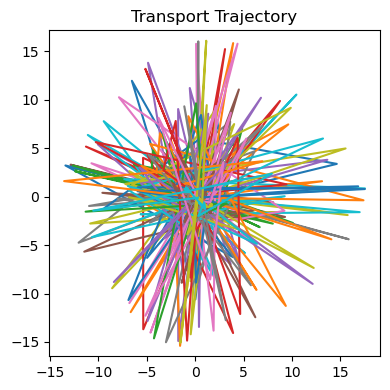

In [10]:
draw_plot(
    BFN,
    z1=samples_1.detach().clone(),
    N=100,
)